<a href="https://colab.research.google.com/github/avindafebriza/kalbe-nutritionals-data-scientist/blob/main/ML_Clustering_Avinda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## READ DATA

In [3]:
df_customer = pd.read_csv('Customer.csv', delimiter=';')
df_product = pd.read_csv('Product.csv', delimiter=';')
df_store = pd.read_csv('Store.csv', delimiter=';')
df_transaction = pd.read_csv('Transaction.csv', delimiter=';')

In [ ]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

## DATA CLEANSING (CUSTOMER)

In [19]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57


In [ ]:
df_customer.duplicated().sum()

In [ ]:
df_customer.isnull().sum()

In [ ]:
df_customer[df_customer['Marital Status'].isnull()]

In [9]:
df_customer.dropna(subset=['Marital Status'], inplace=True)

In [ ]:
df_customer.dtypes

In [13]:
# transformasi tipe data yang tidak sesuai
df_customer['Income'] = df_customer['Income'].replace(',','.',regex=True).astype('float')

## DATA CLEANSING (PRODUCT)

In [15]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [ ]:
df_product.duplicated().sum()

In [ ]:
df_product.isnull().sum()

In [ ]:
df_product.dtypes

## DATA CLEANSING (STORE)

In [27]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529
3,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,5,Bonafid,Gita,General Trade,-7.250445,112.768845


In [ ]:
df_store.duplicated().sum()

In [ ]:
df_store.isnull().sum()

In [ ]:
df_store.dtypes

In [24]:
# transformasi tipe data yang tidak sesuai
df_store['Latitude'] = df_store['Latitude'].replace(',','.',regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace(',','.',regex=True).astype('float')

## DATA CLEANSING (TRANSACTION)

In [43]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,2022-01-01,P3,7500,4,30000,12
1,TR16356,165,2022-01-01,P9,10000,7,70000,1
2,TR1984,183,2022-01-01,P1,8800,4,35200,4
3,TR35256,160,2022-01-01,P1,8800,7,61600,4
4,TR41231,386,2022-01-01,P9,10000,1,10000,4


In [ ]:
df_transaction.duplicated().sum()

In [ ]:
df_transaction.isnull().sum()

In [58]:
df_transaction.dtypes

TransactionID            object
CustomerID                int64
Date             datetime64[ns]
ProductID                object
Price                     int64
Qty                       int64
TotalAmount               int64
StoreID                   int64
dtype: object

In [32]:
# transformasi tipe data yang tidak sesuai
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [ ]:
df_transaction['TransactionID'].value_counts()

In [ ]:
df_transaction[df_transaction['TransactionID'] == 'TR71313']

In [42]:
# menghapus TransactionID yang sama dan menyisakan transaksi paling terbaru
df_cleaned = df_transaction.drop_duplicates(subset=['TransactionID'], keep='last')

In [37]:
df_cleaned.to_csv('cleaned_dataset.csv', index=False)

In [ ]:
print(df_cleaned.head())

In [ ]:
df_cleaned['TransactionID'].value_counts()

In [ ]:
df_cleaned[df_cleaned['TransactionID'] == 'TR71313']

## MERGE DATA

In [45]:
df_merge = pd.merge(df_cleaned, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [46]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [47]:
# identifikasi kolom yang redundant/korelasi tinggi
df_merge.corr()

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.015837,-0.011380,-0.025403,0.006990,-0.022862,-0.017870,0.003156,0.005915,-0.004738
Price,-0.015837,1.000000,-0.355405,0.439146,-0.032526,0.012628,0.011229,0.001667,-0.027900,0.017325
Qty,-0.011380,-0.355405,1.000000,0.621039,0.011340,-0.025567,-0.011661,-0.029621,-0.008228,0.005167
TotalAmount,-0.025403,0.439146,0.621039,1.000000,-0.013560,-0.015795,-0.009794,-0.025999,-0.032737,0.025294
StoreID,0.006990,-0.032526,0.011340,-0.013560,1.000000,-0.004425,-0.002467,0.004311,0.470561,-0.094403
Age,-0.022862,0.012628,-0.025567,-0.015795,-0.004425,1.000000,-0.025092,0.485523,0.010222,0.019690
Gender,-0.017870,0.011229,-0.011661,-0.009794,-0.002467,-0.025092,1.000000,-0.063359,-0.009898,0.000358
Income,0.003156,0.001667,-0.029621,-0.025999,0.004311,0.485523,-0.063359,1.000000,0.018858,0.003488
Latitude,0.005915,-0.027900,-0.008228,-0.032737,0.470561,0.010222,-0.009898,0.018858,1.000000,-0.393919
Longitude,-0.004738,0.017325,0.005167,0.025294,-0.094403,0.019690,0.000358,0.003488,-0.393919,1.000000


In [48]:
df_cluster = df_merge.groupby (['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'Age' : 'first'
}).reset_index()

In [49]:
df_cluster.head()

,CustomerID,TransactionID,Qty,Age
0,1,17,60,55
1,2,12,56,60
2,3,15,56,32
3,4,10,46,31
4,5,7,27,58


In [50]:
data_cluster = df_cluster.drop(columns=['CustomerID'])

data_cluster_normalize = preprocessing.normalize (data_cluster)

In [ ]:
data_cluster_normalize

## KMeans

In [52]:
K = range (2,8)
fits = []
score = []

for k in K:
  model = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(data_cluster_normalize)

  fits.append(model)

  score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

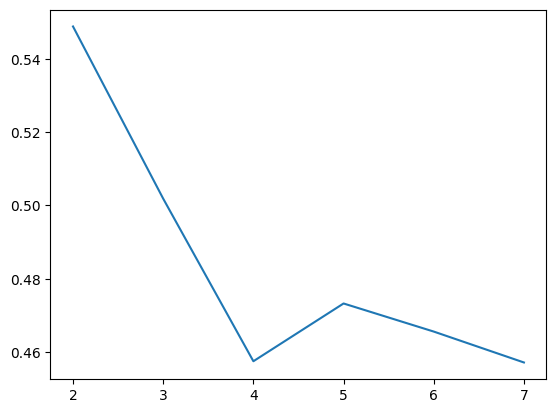

In [53]:
#choose 4 cluster
sns.lineplot(x=K, y=score);

In [54]:
fits[3]

KMeans(n_clusters=5, n_init='auto', random_state=0)

In [55]:
df_cluster['cluster_label'] = fits[3].labels_

In [56]:
 df_cluster

,CustomerID,TransactionID,Qty,Age,cluster_label
0,1,17,60,55,0
1,2,12,56,60,0
2,3,15,56,32,3
3,4,10,46,31,3
4,5,7,27,58,2
...,...,...,...,...,...
439,442,13,37,42,0
440,444,18,62,53,0
441,445,17,62,51,0
442,446,11,42,57,4


In [57]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean',
    'Age' : 'mean'
})

,CustomerID,TransactionID,Qty,Age
cluster_label,,,,
0,120,11.791667,42.166667,41.041667
1,40,13.950000,54.050000,21.900000
2,62,7.500000,24.790323,50.516129
3,109,12.091743,46.128440,31.009174
4,113,9.805310,34.522124,47.575221


- Cluster 0 -> This cluster might represent a group of customers who make moderate-sized purchases (average quantity) and are around 41 years old on average
- Cluster 1 -> This cluster appears to have a smaller customer count but tends to make larger purchases (high average quantity). They are relatively young, with an average age of around 22
- Cluster 2 -> This cluster represents a group of customers with a moderate customer count. They make smaller purchases on average and have a relatively higher average age. (age 50)
- Cluster 3 -> This cluster includes a larger number of customers who make moderately sized purchases and have an average age of around 31 (mayoritas yg belanja)
- Cluster 4 -> This cluster also has a relatively larger customer count. Customers in this cluster make smaller purchases on average and are older, with an average age of around 48.

Summary:
- The number of customers from least to most based on age: 22, 50, 31, 48, 41 (the majority of customers are aged 41).
- The frequency of transactions from least to most based on age: 50, 48, 41, 31, 22 (as customers get older, their shopping interest decreases).
- The amount of spending by each customer from least to most based on age: 50, 48, 41, 31, 21 (as customers get older, their spending decreases).

Business Suggestions:
1. **Creating a Strategy to Attract Young Customers (like a referral program)**:
   - Consider launching a referral program that offers incentives to young customers who refer friends or family to your business. This could include discounts, loyalty points, or free products.
   - Be active on social media platforms used by younger customers, such as Instagram, TikTok, or Snapchat. Posting relevant and engaging content can help reach this audience.

2. **Increasing Shopping Interest Among Older Customers (such as discounts on senior health products)**:
   - Offer products or services that cater to the needs and interests of older customers. For example, senior health products or health programs tailored to their age group.
   - Provide special discounts for older customers. This could include weekly discount days or special discount programs for those above a certain age.

3. **Enhancing Customer Retention (like a loyalty program)**:
   - Implement a loyalty program that allows customers to earn points or rewards every time they shop at your store. These rewards could be in the form of discounts, free products, or exclusive experiences.
   - Send newsletters or emails to customers with special offers, product updates, or useful content to keep them engaged.
   - Create an outstanding customer experience with friendly service, quick response to issues, and effective customer care.

Furthermore, it's important to continuously monitor and analyze your customer data to understand how these efforts are impacting your business. Don't hesitate to make strategy adjustments as needed based on feedback and the results you obtain from your customers.